In [47]:
import numpy as np
import math,struct,pickle
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import copy

In [48]:
def tanh(x):
    return np.tanh(x)

def bypass(x):
    return x

def softmax(x):
    exp=np.exp(x-x.max())   # 为了防止指数爆炸(指数函数)
    # 所以现在就要将其中的减去最大值，变成负数，但是最后是相处，
    #结果都是一样的。
    return exp/exp.sum()

def d_softmax(data):
    sm = softmax(data)
    return np.diag(sm) - np.outer(sm, sm)

def d_tanh(data):  # 返回值返回向量
    return 1 / (np.cosh(data)) ** 2

def d_bypass(x):
    return 1

differential = {softmax: d_softmax, tanh: d_tanh,bypass:d_bypass}
d_type = {bypass:'times',softmax:'dot',tanh:'times'}

In [49]:
dimensions=[28*28,100,10]  # 28*28个神经元,100个神经元是隐藏层，输出的10个数字
# 28*28个神经元先是连接到100个神经元中再连接到10个输出层中
activation =[bypass,tanh,softmax]  # bypass  两个激活函数
distribution=[   # 初始化过程
    {},# 空着
    {'b':[0,0],'w':[-math.sqrt(6/(dimensions[0]+dimensions[1])),math.sqrt(6/(dimensions[0]+dimensions[1]))]},
    {'b':[0,0],'w':[-math.sqrt(6/(dimensions[1]+dimensions[2])),math.sqrt(6/(dimensions[1]+dimensions[2]))]},
]

In [50]:
def init_parameters_b(layer):  # 初始化b
    dist= distribution[layer]['b']
    return np.random.rand(dimensions[layer])*(dist[1]-dist[0])+dist[0]    

def init_parameters_w(layer):
    dist=distribution[layer]['w']
    return np.random.rand(dimensions[layer-1],dimensions[layer])*(dist[1]-dist[0])+dist[0]

def init_parameters():
    parameter=[]   # 迭代每一次的结果
    for i in range (len(distribution)):
        layer_parameter={}   # 存放每一次迭代的数据，并且一直存储起来
        for j in distribution[i].keys():
            if j=='b':
                layer_parameter['b']=init_parameters_b(i)
                continue
            if j=='w':
                layer_parameter['w']=init_parameters_w(i)
                continue
        parameter.append(layer_parameter)
    return parameter

In [51]:
parameters=init_parameters()

In [52]:
def predict(img,parameters):
    # 参数:图片，参数
    l_in=img
    l_out=activation[0](l_in)  # 第一层的初始化
    for layer in range(1,len(dimensions)):  
        l_in = np.dot(l_out,parameters[layer]['w'])+parameters[layer]['b']  # 不断地进行迭代
        l_out = activation[layer](l_in)
    return l_out

In [53]:
predict(train_img[0],init_parameters())

array([0.07210171, 0.07957606, 0.13152407, 0.05420442, 0.08498909,
       0.12788144, 0.14911174, 0.14570486, 0.08225591, 0.07265069])

In [54]:
dataset_path=Path('D:/Desktop/MNIST')

In [55]:
train_img_path=dataset_path/'train-images-idx3-ubyte/train-images.idx3-ubyte'
train_lab_path=dataset_path/'train-labels-idx1-ubyte/train-labels.idx1-ubyte'
test_img_path=dataset_path/'t10k-images-idx3-ubyte/t10k-images.idx3-ubyte'
test_lab_path=dataset_path/'t10k-labels-idx1-ubyte/t10k-labels.idx1-ubyte'

In [56]:

train_num = 50000  # 训练
valid_num = 10000  # 验证
test_num = 10000  # 测试

with open(train_img_path, 'rb') as f:
    struct.unpack('>4i', f.read(16))
    temp_img = np.fromfile(f, dtype=np.uint8).reshape(-1, 28 * 28) / 255
    train_img = temp_img[:train_num]  # 将训练集中的数据分了1w出去给验证
    valid_img = temp_img[train_num:]

with open(test_img_path, 'rb') as f:
    struct.unpack('>4i', f.read(16))
    test_img = np.fromfile(f, dtype=np.uint8).reshape(-1, 28 * 28) / 255

with open(train_lab_path, 'rb') as f:
    struct.unpack('>2i', f.read(8))
    temp_lab = np.fromfile(f, dtype=np.uint8)
    train_lab = temp_lab[:train_num]
    valid_lab = temp_lab[train_num:]

with open(test_lab_path, 'rb') as f:
    struct.unpack('>2i', f.read(8))
    test_lab = np.fromfile(f, dtype=np.uint8)



In [57]:
def show_train(index):
    plt.imshow(train_img[index].reshape(28, 28), cmap='gray')
    pylab.show()
    print('label:{}'.format(train_lab[index]))


def show_valid(index):
    plt.imshow(valid_img[index].reshape(28, 28), cmap='gray')
    pylab.show()
    print('label:{}'.format(valid_lab[index]))


def show_test(index):
    plt.imshow(test_img[index].reshape(28, 28), cmap='gray')
    pylab.show()
    print('test:{}'.format(test_lab[index]))



In [58]:
predict(np.random.rand(784),parameters)

array([0.0942381 , 0.11644771, 0.05850607, 0.23711087, 0.02732923,
       0.0176975 , 0.19317991, 0.14196864, 0.08510021, 0.02842176])

In [59]:
h = 0.0001
func = softmax
input_len = 4
for i in range(input_len):  # 两种求导数的方法
    # 一种是定义方法，与一种是直接求导法
    test_input = np.random.rand(input_len)
    derivative = differential[func](test_input)
    value1 = func(test_input)
    test_input[i] += h
    value2 = func(test_input)
    # print((value2 - value1) / h)
    # print(derivative[i] - (value2 - value1) / h)  # 差值

onehot = np.identity(dimensions[-1])  # 10个数字


In [60]:

def sqr_loss(img, lab, parameters):
    y_pred = predict(img, parameters)
    y = onehot[lab]
    diff = y - y_pred
    return np.dot(diff, diff)


def grad_parameters(img, lab, parameters):
    # 参数:图片，参数
    l_in_list=[img] # 第一个参数是0所以img+0是等于img
    l_out_list=[activation[0](l_in_list[0])]  # 第一个out也是初始化之后的out
    for layer in range(1,len(dimensions)):  
        l_in = np.dot(l_in_list[layer-1], parameters[layer]['w']) + parameters[layer]['b']
        l_out = activation[layer](l_in)
        l_in_list.append(l_in)
        l_out_list.append(l_out)
        
    d_layer =-2*(onehot[lab] - l_out_list[-1])
    grad_result=[None]*len(dimensions)
    for layer in range(len(dimensions)-1,0,-1):  # 反向传播
        if d_type[activation[layer]]=='times':
            d_layer = differential[activation[layer]](l_in_list[layer])*d_layer
        if d_type[activation[layer]]=='dot':
            d_layer = np.dot(differential[activation[layer]](l_in_list[layer]), d_layer)
        # 参数一:
        grad_result[layer]={}
        grad_result[layer]['b'] = d_layer
        grad_result[layer]['w'] = np.outer(l_out_list[layer-1], d_layer)  # 上一层的结果
        d_layer = np.dot(parameters[layer]['w'],d_layer)
    return grad_result 


In [61]:
grad_parameters(train_img[0],train_lab[0],init_parameters())

[None,
 {'b': array([-1.62302459e-02, -1.91254920e-02, -3.73749753e-03, -1.66786124e-02,
         -2.12022373e-02, -1.04646586e-03,  9.63316341e-03,  6.90735379e-03,
          1.61556380e-02, -3.33807296e-02,  1.49356656e-02,  9.24391644e-04,
          1.77329013e-02, -3.72724560e-03,  6.64584266e-03,  1.09813199e-02,
         -3.97027340e-03, -3.36545429e-03, -9.17164181e-03, -7.24943687e-03,
         -9.21419464e-03, -2.48986823e-02,  1.82670960e-02, -1.18329628e-02,
          1.91216237e-02, -4.66337187e-03,  1.29561261e-02,  7.70495908e-04,
          1.58896760e-02, -5.97246187e-03,  7.95289534e-03, -1.39090002e-04,
          6.57986164e-03,  1.57883472e-02,  1.57148626e-02,  3.59447680e-02,
         -2.47554471e-03,  1.59274783e-02, -7.60933810e-03,  8.56771816e-03,
          4.99572351e-03, -1.43540360e-02, -4.61758475e-03, -3.12684087e-03,
         -1.05141694e-03, -4.81626250e-03,  1.87207746e-03,  3.08868206e-02,
         -3.44192104e-03, -3.10807909e-03,  2.13287774e-02, -3.2

In [62]:
h = 0.00001  # 验证方向传递求的对不对，求导过程。
layer=2
parameters = init_parameters()
pname='b'
for i in range(len(parameters[layer][pname])):  # 两种求导数的方法
    # 一种是定义方法，与一种是直接求导法
    img_i = np.random.randint(train_num)  # 随机找数字图片
    test_parameters = init_parameters()  # 随机找
    derivative = grad_parameters(train_img[img_i], train_lab[img_i], test_parameters)[layer][pname]
    value1 = sqr_loss(train_img[img_i], train_lab[img_i], test_parameters)
    test_parameters[layer][pname][i] += h
    value2 = sqr_loss(train_img[img_i], train_lab[img_i], test_parameters)
    print(derivative[i]-(value2-value1)/h)


0.0020764165781846783
-0.001386329419766985
-0.004611191426938075
0.0005164177436246201
-0.0006500774190536535
0.012857276524635919
-0.003971546791413389
-0.005857217500977091
0.0014161048275444857
0.0067659469632722555


In [68]:
h = 0.00001  # 验证方向传递求的对不对，求导过程。
layer=1
parameters = init_parameters()
pname='w'
grad_list=[]
for i in range(len(parameters[layer][pname])):  # 两种求导数的方法
    for j in range(len(parameters[layer][pname][0])): 
        img_i = np.random.randint(train_num)  # 随机找数字图片
        test_parameters = init_parameters()  # 随机找
        derivative = grad_parameters(train_img[img_i], train_lab[img_i], test_parameters)[layer][pname]
        value1 = sqr_loss(train_img[img_i], train_lab[img_i], test_parameters)
        test_parameters[layer][pname][i][j] += h
        value2 = sqr_loss(train_img[img_i], train_lab[img_i], test_parameters)
        grad_list.append(derivative[i][j]-(value2-value1)/h)
np.abs(grad_list).max()

0.024755887506319844

In [ ]:
def valid_loss(parameters):  # 验证集函数
    loss_accu = 0
    for img_i in range(valid_num):
        loss_accu += sqr_loss(valid_img[img_i], valid_lab[img_i], parameters)
    return loss_accu / (valid_num / 10000)  # 每1w张图片的loss_accu
    # 进行归一化，1w个图片为整体

    
def valid_accuracy(parameters):  # 准确率
    correct = [predict(valid_img[img_i], parameters).argmax() == valid_lab[img_i] for img_i in range(valid_num)]
    return correct.count(True) / len(correct)


def train_loss(parameters):   # 验证集函数
    loss_accu = 0
    for img_i in range(train_num):
        loss_accu += sqr_loss(train_img[img_i], train_lab[img_i], parameters)
    return loss_accu / (train_num / 10000)


def train_accuracy(parameters):  # 准确率
    correct = [predict(train_img[img_i], parameters).argmax() == train_lab[img_i] for img_i in range(train_num)]
    return correct.count(True) / len(correct)

def test_accuracy(parameters):  # 准确率
    correct = [predict(test_img[img_i], parameters).argmax() == test_lab[img_i] for img_i in range(test_num)]
    return correct.count(True) / len(correct)


In [103]:
def grad_add(grad1,grad2):
    for layer in range(1,len(grad1)):
        for pname in grad1[layer].keys():
            grad1[layer][pname]+=grad2[layer][pname]
    return grad1
    
def grad_divide(grad,denominator):
    for layer in range(1,len(grad)):
        for pname in grad[layer].keys():
            grad[layer][pname]/=denominator
    return grad
    
def combine_parameters(parameters, grad, learn_rate):  # 新的参数的形成
    parameter_tmp = copy.deepcopy(parameters)
    for layer in range(len(parameter_tmp)):
        for pname in parameter_tmp[layer].keys():
            parameter_tmp[layer][pname] -= learn_rate * grad[layer][pname]
    return parameter_tmp

In [101]:
batch_size = 100  # 一百张图片为整体
# 100张图片当一小块
# 训练一小块
def train_batch(current_batch, parameters):  # 将这一百张图片的梯度计算起来，拿到一个平均值！
    grad_accu = grad_parameters(train_img[current_batch * batch_size], train_lab[current_batch * batch_size],
                                parameters)
    for img_i in range(1, batch_size):
        grad_temp = grad_parameters(train_img[current_batch * batch_size + img_i],
                                    train_lab[current_batch * batch_size + img_i], parameters)
        grad_add(grad_accu,grad_temp)
            # 获得累加的梯度
    grad_divide(grad_accu,batch_size)    # 拿到方向
    return grad_accu

In [99]:
parameters = init_parameters()

In [ ]:
from tqdm import tqdm_notebook
current_epoch = 0
train_loss_list = []  # 存储loss的数值
valid_loss_list = []  # 存储验证的loss的数值
train_accu_list = []  # 训练的正确性
valid_accu_list = []  # 验证集的正确性
learn_rate = 10**-0.3  # 学习率到最后要变小
epoch_num = 5  # 训练的次数  训练完一次叫一个epoch
for epoch in tqdm_notebook(range(epoch_num)):
    for i in range(train_num // batch_size):
#         if i % 100 == 99:
#             print('running batch{}/{}'.format(i + 1, train_num // batch_size))
        grad_tmp = train_batch(i, parameters)
        parameters = combine_parameters(parameters, grad_tmp, learn_rate)
    current_epoch += 1
    train_loss_list.append(train_loss(parameters))
    train_accu_list.append(train_accuracy(parameters))
    valid_loss_list.append(valid_loss(parameters))
    valid_accu_list.append(valid_accuracy(parameters))

In [112]:
valid_accuracy(parameters)

0.9146

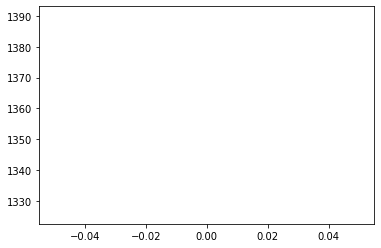

In [113]:
lower = -0
plt.plot(valid_loss_list[lower:], color='black', label='validation loss')
plt.plot(train_loss_list[lower:], color='red', label='train loss')
plt.show()

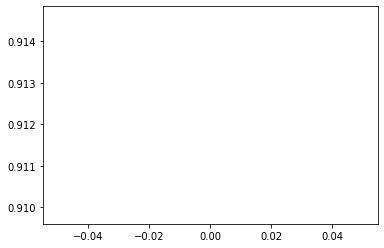

In [114]:
plt.plot(valid_accu_list[lower:], color='black', label='validation accuracy')
plt.plot(train_accu_list[lower:], color='red', label='train accuracy')
plt.show()